c:\Users\KAR.SACI\AppData\Local\anaconda3\envs\env_cd_ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(



===== SAISONS CALCULÉES =====

        Début         Fin   Saison
0  2025-01-01  2025-03-02    Basse
1  2025-01-02  2025-03-20    Basse
2  2025-03-21  2025-05-14  Moyenne
3  2025-05-15  2025-07-02    Haute
4  2025-07-03  2025-09-03  Moyenne
5  2025-09-04  2025-10-23    Haute
6  2025-10-24  2025-12-31  Moyenne


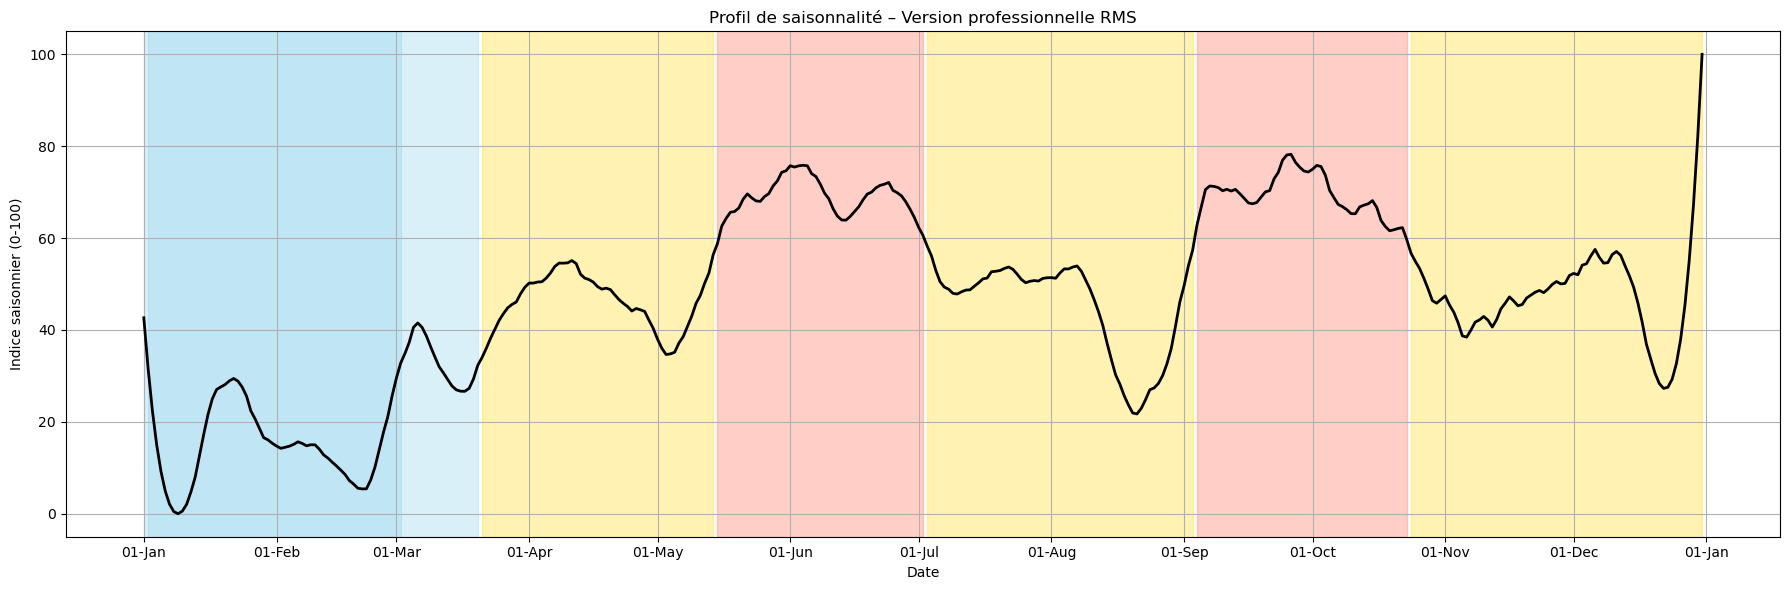

In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 1. Chargement des données
# -------------------------------------------------------------
hotCode='0GW' #'6N8'   

df = pd.read_csv('../data/'+hotCode+'/Indicateurs.csv', sep=';')
df.fillna(0, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

# -------------------------------------------------------------
# 2. Construire un profil moyen par "jour de l'année" (1..365)
# -------------------------------------------------------------
df['DayOfYear'] = df['Date'].dt.dayofyear

# Indicateurs utiles : TO ou CaH ou PM
metric = "To"

profile = (
    df.groupby('DayOfYear')[metric]
    .mean()
    .reindex(range(1,366))
    .interpolate()  # interpoler les jours manquants
)

# -------------------------------------------------------------
# 3. Lissage avancé (Savitzky-Golay)
# -------------------------------------------------------------
# fenêtre = 21 jours, ordre = 3
smooth = savgol_filter(profile.values, window_length=21, polyorder=3)

# -------------------------------------------------------------
# 4. Normalisation 0–100 (indice saisonnier)
# -------------------------------------------------------------
scaler = MinMaxScaler(feature_range=(0, 100))
season_index = scaler.fit_transform(smooth.reshape(-1,1)).flatten()

# -------------------------------------------------------------
# 5. Clustering NON SUPERVISÉ (3 saisons)
# -------------------------------------------------------------
X = season_index.reshape(-1,1)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)

# Ordonnancer les clusters du plus faible au plus fort
order = np.argsort(kmeans.cluster_centers_.flatten())
label_map = {old: new for new, old in enumerate(order)}
season_labels = np.vectorize(label_map.get)(labels)

# 0 = basse, 1 = moyenne, 2 = haute
season_names = np.where(season_labels == 2, "Haute",
                np.where(season_labels == 1, "Moyenne", "Basse"))

# -------------------------------------------------------------
# 6. Reconstruction de périodes continues
# -------------------------------------------------------------
def extract_periods(day_labels):
    periods = []
    current_season = day_labels[0]
    start_day = 1

    for day in range(2, 366):
        if day_labels[day-1] != current_season:
            periods.append((start_day, day-1, current_season))
            start_day = day
            current_season = day_labels[day-1]

    periods.append((start_day, 365, current_season))
    return periods

periods = extract_periods(season_labels)

# -------------------------------------------------------------
# 7. Correction professionnelle RMS :
#    Fusion des segments trop courts (< 14 jours)
# -------------------------------------------------------------
def merge_short_segments(periods, min_len=14):
    merged = []

    for i, (s, e, lab) in enumerate(periods):
        if (e - s + 1) < min_len:
            # trop court : fusionner avec segment précédent si possible
            if merged:
                prev_s, prev_e, prev_lab = merged[-1]
                merged[-1] = (prev_s, e, prev_lab)
            else:
                # fusionner avec le suivant
                next_s, next_e, next_lab = periods[i+1]
                merged.append((s, next_e, next_lab))
        else:
            merged.append((s, e, lab))

    return merged

clean_periods = merge_short_segments(periods)

# -------------------------------------------------------------
# 8. Convertir DOY → Dates réelles
#     (exemple pour l'année 2025, adaptable)
# -------------------------------------------------------------
base_year = 2025

result_periods = []
for s, e, lab in clean_periods:
    start_date = pd.to_datetime(f"{base_year}-01-01") + pd.Timedelta(days=s-1)
    end_date   = pd.to_datetime(f"{base_year}-01-01") + pd.Timedelta(days=e-1)
    name = ["Basse", "Moyenne", "Haute"][lab]
    result_periods.append((start_date.date(), end_date.date(), name))

result_df = pd.DataFrame(result_periods, columns=["Début", "Fin", "Saison"])

print("\n===== SAISONS CALCULÉES =====\n")
print(result_df)

# -------------------------------------------------------------
# 9. Visualisation professionnelle
# -------------------------------------------------------------
import matplotlib.dates as mdates

plt.figure(figsize=(18,6))

# Convert DOY (1-365) to actual date strings (e.g. "01-jan", "15-mar", etc)
base_year = 2025
dates = pd.date_range(start=f"{base_year}-01-01", periods=365)
# Courbe saisonnière lissée
plt.plot(dates, season_index, color="black", linewidth=2, label="Indice saisonnier")

# Coloration par saison
colors = {0: "skyblue", 1: "gold", 2: "tomato"}

for s, e, lab in clean_periods:
    date_s = dates[s-1]
    date_e = dates[e-1]
    plt.axvspan(date_s, date_e, alpha=0.3, color=colors[lab])

plt.title("Profil de saisonnalité – Version professionnelle RMS")
plt.xlabel("Date")
plt.ylabel("Indice saisonnier (0-100)")
plt.grid(True)

# Set x-axis major ticks for every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

plt.tight_layout()
plt.show()
